# Modelo MLP para Previsão de Preços de Criptomoedas

## Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, PReLU
from tensorflow.keras.optimizers import Adam
import joblib

## PASSO 1: Carregar e Preparar os Dados

**Objetivo:** Ler o arquivo CSV e garantir que ele esteja em ordem.

In [333]:
# Carrega os dados do arquivo CSV
df = pd.read_csv(r"C:\Users\david\Desktop\trading-algoritmico\data\fechamentos\SOLUSDT_15m_data.csv")

# Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df = df.reset_index(drop=True)

# Remove colunas com nomes "Unnamed".
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(f"Dados carregados: {df.shape[0]} registros.")
print(df.head())

Dados carregados: 70080 registros.
            timestamp   open   high    low  close     volume
0 2023-07-20 15:30:00  26.20  26.21  25.75  25.91  121467.56
1 2023-07-20 15:45:00  25.90  25.91  25.57  25.69  191787.08
2 2023-07-20 16:00:00  25.69  25.77  25.56  25.66  106474.05
3 2023-07-20 16:15:00  25.67  25.67  25.21  25.37  170476.73
4 2023-07-20 16:30:00  25.38  25.47  25.33  25.42   75885.50


## PASSO 2: Preparar os Dados para o Modelo

**Objetivo:** Transformar os dados brutos em um formato que a rede neural entenda (features e target).

In [334]:
# --- Calculo dos Indicadores ---
# Calcula as variações percentuais de 'close' e 'volume'
df['close_pct'] = df['close'].pct_change()
df['volume_pct'] = df['volume'].pct_change()

# Calcula a média móvel simples de 10 e 30 períodos para 'close'
df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_30'] = df['close'].rolling(window=30).mean()

# Calcula o Índice de Força Relativa (RSI) de 14 períodos
def rsi(series, period=14):
    gain = (series.where(series > 0, 0)).rolling(window=period).mean()
    loss = (-series.where(series < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
df['rsi'] = rsi(df['close'])

# Calcula o MACD
def macd(series, short_window=12, long_window=26, signal_window=9):
    exp1 = series.ewm(span=short_window, adjust=False).mean()
    exp2 = series.ewm(span=long_window, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line
df['macd'], df['macd_signal'] = macd(df['close'])

# Calcula o Bollinger Bands
def bollinger_bands(series, window=20, num_std_dev=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band
df['bb_upper'], df['bb_lower'] = bollinger_bands(df['close'])

# Calcula o desvio padrão de 10, 20 e 40 períodos
df['std_10'] = df['close'].rolling(window=10).std()
df['std_20'] = df['close'].rolling(window=20).std()
df['std_40'] = df['close'].rolling(window=40).std()

# Calcula a média móvel exponencial de 10 e 30 períodos
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Apaga as linhas com valores NaN
df = df.dropna()
df = df.reset_index(drop=True)


In [335]:
# --- Definição das Variáveis ---
FEATURE_COLUMNS = ['close_pct', 'volume_pct', 'sma_10', 'sma_30', 'rsi', 'macd', 'macd_signal', 
                   'bb_upper', 'bb_lower', 'std_10', 'std_20', 'std_40', 'ema_10', 'ema_30']
TARGET_COLUMN = 'close'

# SEQUENCE_LENGTH: Quantos períodos olharemos para trás para prever o próximo.
SEQUENCE_LENGTH = 16

# --- Criação das Features (X) e do Alvo (y) ---
# O alvo (y) será binário: 1 se o preço subir, 0 se não.
# df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período.
y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

# As features (X) serão os dados OHLCV.
X_raw = df[FEATURE_COLUMNS]

print(f"Features definidas: {FEATURE_COLUMNS}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Shape dos dados brutos: {X_raw.shape}")

Features definidas: ['close_pct', 'volume_pct', 'sma_10', 'sma_30', 'rsi', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'std_10', 'std_20', 'std_40', 'ema_10', 'ema_30']
Sequence length: 16
Shape dos dados brutos: (70041, 14)


In [336]:
# --- Normalização dos Dados ---
# Importante para redes neurais, pois ajuda na convergência do modelo
scaler = QuantileTransformer()
X_scaled = scaler.fit_transform(X_raw)

print(f"Dados normalizados. Shape: {X_scaled.shape}")
print(f"Min: {X_scaled.min()}, Max: {X_scaled.max()}")

Dados normalizados. Shape: (70041, 14)
Min: 0.0, Max: 1.0


In [337]:
# --- Criação das Sequências ---
# Cria sequências de dados para o modelo
X_sequences, y_sequences = [], []
for i in range(len(X_scaled) - SEQUENCE_LENGTH):
    X_sequences.append(X_scaled[i : i + SEQUENCE_LENGTH])
    y_sequences.append(y[i + SEQUENCE_LENGTH -1]) # O alvo corresponde ao final da sequência

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")

Sequências criadas. X shape: (70025, 16, 14), y shape: (70025,)


In [338]:
# --- Reshape do X para o MLP ---
# O MLP espera uma entrada 2D, então precisa achatar as sequências
num_samples = X.shape[0]
num_features_flat = X.shape[1] * X.shape[2]
X = X.reshape(num_samples, num_features_flat)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (alvo): {y.shape}")

Shape de X (features): (70025, 224)
Shape de y (alvo): (70025,)


In [339]:
# --- Divisão em Treino e Teste ---
# Divisão dos dados em treino e teste
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Tentativa de balancear as classes, evitando a mesma reposta sempre
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Amostras de treino: {len(X_train)}")
print(f"Amostras de teste: {len(X_test)}")
print(f"Distribuição do target no treino: {np.bincount(y_train)}")
print(f"Distribuição do target no teste: {np.bincount(y_test)}")

Amostras de treino: 56020
Amostras de teste: 14005
Distribuição do target no treino: [28310 27710]
Distribuição do target no teste: [7016 6989]


## PASSO 3: Construir o Modelo (MLP)

**Objetivo:** Definir a arquitetura da nossa rede neural.

In [340]:
model = Sequential()

# Camada de Entrada: Define o formato da nossa entrada
model.add(Input(shape=(num_features_flat,)))

# 1ª Camada Oculta: Primeira camada que aprende os padrões
model.add(Dense(units=128))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())  

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.3))

# 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
model.add(Dense(units=64))

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.3))

# Camada de Saída: Gera a previsão final
model.add(Dense(units=1, activation='sigmoid'))

In [341]:
# --- Compilação do Modelo ---
# O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 128)            │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_32 (PReLU)              │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_33 (PReLU)              │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,313 (145.75 KB)

 Trainable params: 37,313 (145.75 KB)

 Non-trainable params: 0 (0.00 B)

## PASSO 4: Treinar o Modelo

**Objetivo:** Alimentar o modelo com os dados de treino para que ele aprenda.

In [ ]:
# Callbacks para otimizar o treinamento 
callbacks = [ 
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)]

history = model.fit(
    X_train,
    y_train,
    epochs=200,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
    batch_size=32,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
    validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
    class_weight=class_weight_dict,  # Pesos das classes para lidar com desbalanceamento
    callbacks=callbacks,  # Callbacks para otimização do treinamento
    verbose=1 # Mostra uma barra de progresso.
)

Epoch 1/200
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4990 - loss: 0.6990 - val_accuracy: 0.5005 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/200
1270/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5082 - loss: 0.6934

## PASSO 5: Avaliar o Modelo

**Objetivo:** Verificar o quão bem o modelo se saiu nos dados de teste.

In [ ]:
# Fazer previsões nos dados de teste. A saída será uma probabilidade
probabilities = model.predict(X_test)

# Converter probabilidades em classes (0 ou 1) usando um limiar de 0.5
predictions = (probabilities > 0.5).astype(int)

print(probabilities)
# Calcular e mostrar as métricas
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions, target_names=['Não Sobe', 'Sobe'])

print(f"Acurácia no Teste: {accuracy * 100:.2f}%")
print("\nRelatório de Classificação:")
print(report)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
[[0.49877322]
 [0.49801245]
 [0.49655214]
 ...
 [0.50785244]
 [0.5125769 ]
 [0.5058422 ]]
Acurácia no Teste: 51.68%

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Sobe       0.52      0.39      0.45      7016
        Sobe       0.51      0.64      0.57      6989

    accuracy                           0.52     14005
   macro avg       0.52      0.52      0.51     14005
weighted avg       0.52      0.52      0.51     14005




Matriz de Confusão:


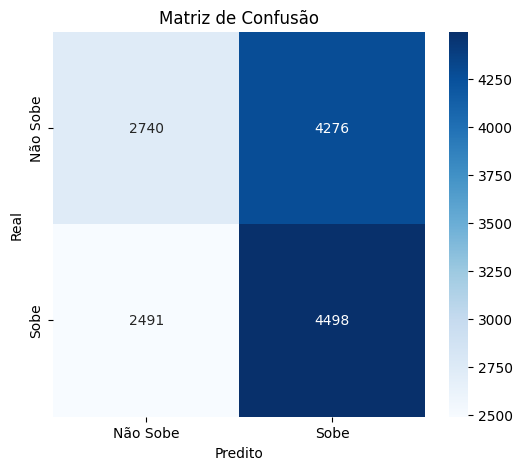

In [ ]:
print("\nMatriz de Confusão:")
# Um mapa de calor para visualizar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## PASSO 6: Visualizar o Treinamento

**Objetivo:** Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.

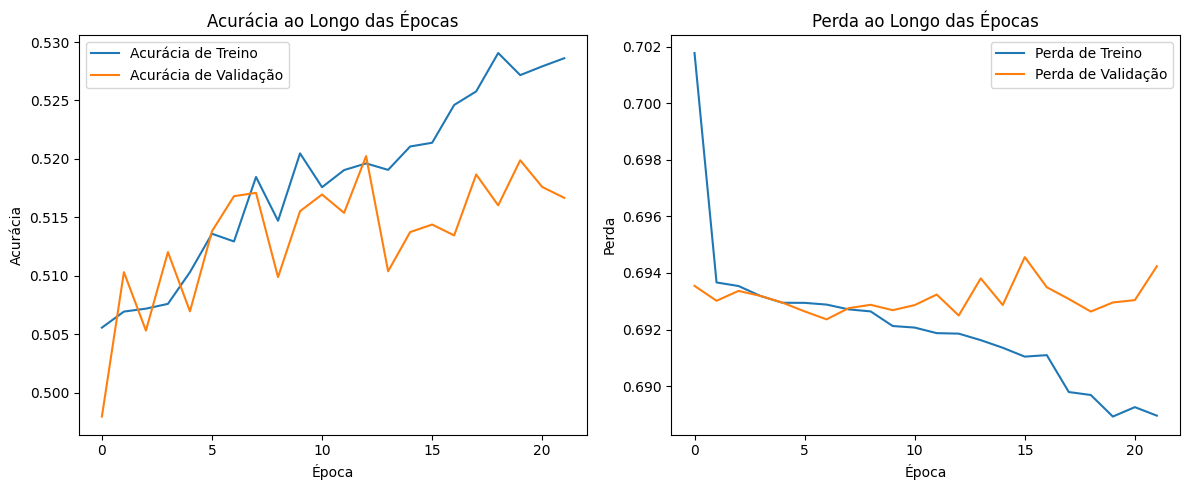

In [ ]:
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

## PASSO 7: Salvar o Modelo

**Objetivo:** Salvar o modelo treinado e o normalizador para uso futuro.

In [ ]:
# Por enquanto não é necessário salvar o modelo
'''
MODEL_PATH = "mlp_basic_model.h5"
SCALER_PATH = "basic_scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"Modelo salvo em: {MODEL_PATH}")
print(f"Normalizador salvo em: {SCALER_PATH}")
'''

'\nMODEL_PATH = "mlp_basic_model.h5"\nSCALER_PATH = "basic_scaler.pkl"\n\nmodel.save(MODEL_PATH)\njoblib.dump(scaler, SCALER_PATH)\n\nprint(f"Modelo salvo em: {MODEL_PATH}")\nprint(f"Normalizador salvo em: {SCALER_PATH}")\n'

## Conclusão

### Já integrado:

1. **Carrega dados históricos**
2. **Prepara os dados**
3. **Constrói um MLP**
4. **Treina o modelo**
5. **Avalia o desempenho**
6. **Visualiza o treinamento**
7. **Salva o modelo**

### Próximos Passos:
- ENTENDER POR QUE O MODELO SÓ FALA QUE VAI SUBIR (ERA POR CAUSA DO MINMAXSCALER, POR TER MUITOS OUTLIERS ELE APERTAVA VALORES INTERMEDIARIOS EM UM INTERVALO MUITO PEQUENO... TROQUEI PARA STANDARDSCALER)
- Adicionar features técnicas, prepara-las e dar ao treino do modelo
- Implementar validação cruzada temporal
- Testar diferentes janelas temporais